In [2]:
##Installing and importing necessary libraries
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [3]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 66.1.0 which is incompatible.


In [9]:
!pip install gym[box2d] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp38-cp38-linux_x86_64.whl size=2834731 sha256=3d25f1e43c53c35c32a18b743ecc83dad075defc422c2b54bd6b5b745f257e60
  Stored in directory: /root/.cache/pip/wheels/8b/95/16/1dc99ff9a3f316ff245fdb5c9086cd13c35dad630809909075
Successfully built box2d-py


In [4]:
##Importing necessary libraries
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
from gym.wrappers.monitoring import video_recorder
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [5]:
from pyvirtualdisplay import Display

# this code is used to start a virtual display to run a graphical application on a headless server.
# This line of code creates a new object of the class "Display" and starts it. 
#The object is created with two arguments, "visible" and "size". 
#The "visible" argument is set to 0, which means the display will not be visible to the user. 
#The "size" argument is set to (1400, 900), which sets the width and height of the display in pixels.
display = Display(visible=0, size=(1400, 900))

#The start method is used to start the display.
display.start()

In [6]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('final_video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
#this function is used to record the video of the environment, and the RL agent pplaying the lunar lander game.
def wrap_env(env):
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  return env

In [10]:
env = wrap_env(gym.make("LunarLander-v2"))

In [11]:
import tensorflow as tf

#This code snippet is checking for physical devices that are compatible with TensorFlow, such as a GPU or TPU.
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0


In [12]:
#import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear

import numpy as np
#env = gym.make('LunarLander-v2')
env.seed(0)
np.random.seed(0)



with tf.device('/GPU:0'):

  class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .996
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()

    #The method creates a Sequential model using the Keras library, which is a neural network model. 
    #The model has three layers: an input layer, a hidden layer, and an output layer. 
    #The input layer has 150 neurons and the input dimension is determined by the "state_space" attribute of the class. 
    #The activation function for the input and hidden layers is "relu" (rectified linear unit), which is a common activation function used in neural networks. 
    #The output layer has the same number of neurons as the "action_space" attribute of the class and the activation function is "linear". 
    #The model is then compiled with a mean squared error loss function and the Adam optimizer with a learning rate specified by the "lr" attribute of the class. 
    #The method returns the created model.
    def build_model(self):

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model


    #This method is used to store information about the previous experiences of the agent in a reinforcement learning algorithm, 
    #such as the state, action, reward, and next state of the agent at a given point in time, 
    #and whether or not the agent has reached a terminal state.
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


    #This is a function that implements an epsilon-greedy algorithm for selecting actions in the reinforcement learning agent. 
    #The function takes in the current state of the agent and returns an action to take.
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state, verbose = False)
        return np.argmax(act_values[0])


    #This code defines the replay method for the Q-learning agent.
    #The method first checks if there are enough experiences stored in the agent's memory to sample a minibatch from. If there are, it randomly samples a minibatch of experiences from memory, and then separates the experiences into states, actions, rewards, next states, and done flags.
    #These minibatch of experiences will be used to train the agent's neural network. Then the method then uses the Q-learning update rule to compute the targets for the training, which are the expected return of the agent's policy. 
    #Finally, the agent's neural network is trained on the states and targets, and the agent's exploration rate, epsilon, is decayed.
    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

  
  
  #This code trains the deep Q-network (DQN) agent on the lunarlander environment.
  #The function takes an input of the number of episodes to train the agent for. 
  def train_dqn(episode):

    loss = []
    # The function creates an instance of a DQN agent and initializes an empty list to store the score from each episode. 
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    
    #The function then runs a loop for the specified number of episodes, in which it resets the environment to the starting state, reshapes the state to match the size expected by the DQN agent, initializes the score for the episode to zero. 
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 8))
        score = 0
        max_steps = 3000

        #runs another loop for a maximum number of steps per episode.
        for i in range(max_steps):
            #In each step, the agent selects an action using its "act" method, the environment is rendered, the agent receives a reward and the next state from the environment, the agent's memory is updated with this experience, the agent's neural network is trained by replaying a random batch of experiences, and the agent's state is updated to the next state.
            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 8))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                #show_video()
                break
        loss.append(score)

        # Average score of last 100 episode
        is_solved = np.mean(loss[-100:])

        #if the agent's average score over the last 100 episodes is greater than 50, the agent's model is saved and the environment is closed, and the function ends. The function then returns the list of scores from each episode.
        if is_solved > 50:
            agent.model.save("joshua's_model.h5")
            env.close()
            show_video()
            print('\n Task Completed! \n')
            break
        print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
        
    return loss





Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Discrete(4)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode: 0/200, score: -115.60678601416666
Average over last 100 episode: -115.61 

episode: 1/200, score: -97.39294718355953
Average over last 100 episode: -106.50 

episode: 2/200, score: -117.25195712816824
Average over last 100 episode: -110.08 

episode: 3/200, score: -327.5157157025553
Average over last 100 episode: -164.44 

episode: 4/200, score: -391.6687340148724
Average over last 100 episode: -209.89 

episode: 5/200, score: -143.46330334751755
Average over last 100 episode: -198.82 

episode: 6/200, score: -179.3623480173467
Average over last 100 episode: -196.04 

episode: 7/200, score: -1.271428511569499
Average over last 100 episode: -171.69 

episode: 8/200, score: -336.9151463488992
Average over last 100 episode: -190.05 

episode: 9/200, score: -126.19083611692373
Average over last 100 episode: -183.66 

episode: 10/200, score: -110.55860437623741
Average over last 100 episode: -177.02 

episode: 11/200, score: -194.95395285003906
Average over last 100 episode: -178.5

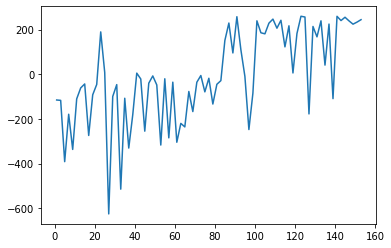

In [13]:
#This code is checking if the current script is being run as the main program (i.e., not imported as a module). If it is, it prints the observation space and action space of an environment variable, "env". Then it calls a function "train_dqn" with the number of episodes as an argument and assigns the returned value to the variable "loss". Finally, it plots the loss variable using matplotlib and displays the plot.
if __name__ == '__main__':

   print(env.observation_space)
   print(env.action_space)
   episodes = 200
   loss = train_dqn(episodes)
   plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
   plt.show()

In [1]:
#Loading the DQN model called "joshua's_model.h5" using the load_model function from the keras.models module. Once the model is loaded, it is stored in the variable Q_table. This model can then be used for various tasks such as prediction, evaluation
from keras.models import load_model
Q_table = load_model("/content/joshua's_model.h5")

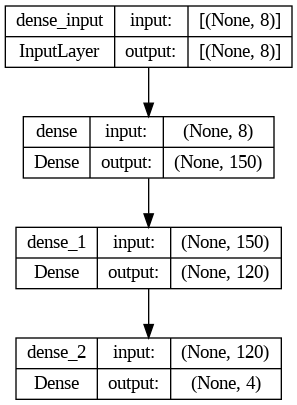

In [2]:
#Plotting the model architecture
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(Q_table, to_file='DQN_Lunarlander_Josh.png', show_shapes=True)

To obtain Q-value for a given state-action pair is using the neural network (Q-network) which the DQN model is using. We use the predict method of the model and feed the state-action pair to it, it will return the Q-value for the given state-action pair as an output of the neural network

In [23]:
#Q_value for a given action-state pair
state_high = env.observation_space.high
state_high = np.reshape(state_high, (1,8))
q_values_high = Q_table.predict(state_high)

1/1 [==============================] - 0s 24ms/step


In [24]:
state_low = env.observation_space.low
state_low = np.reshape(state_low, (1,8))
q_values_low = Q_table.predict(state_low)

1/1 [==============================] - 0s 36ms/step


In [27]:
import pandas as pd

We create a DataFrame called "Q_table" with 4 columns named 'Do nothing (0)', 'Fire left engine (1)', 'Fire main engine (2)', and 'Fire right engine (3)'. It also has 2 rows named 'State_low' and 'State_high'. The values in the first row are set to the values in the variable 'q_values_low' and the values in the second row are set to the values in the variable 'q_values_high'. Finally, the code displays the Q_table.

In [30]:
Q_table = pd.DataFrame(columns = ['Do nothing (0)','Fire left engine (1)','Fire main engine (2)','Fire right engine (3)'], index = ['State_low','State_high'])
Q_table.iloc[0]= q_values_low
Q_table.iloc[1]= q_values_high

Q_table

,Do nothing (0),Fire left engine (1),Fire main engine (2),Fire right engine (3)
State_low,-620.136292,-667.597839,-696.445374,-700.967468
State_high,-669.637329,-812.516479,-805.203186,-656.681763
